In [158]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk import collocations
import re, string
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import sparse
from sklearn import linear_model
plt.rcParams['figure.figsize'] = [16, 6]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johancanales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johancanales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [159]:
def getxy(row_s, row_f, feature_cols=['followers', 'following', 'retweet'], label_col=['troll']):
    return df[feature_cols][row_s:row_f], df[label_col][row_s:row_f]


In [160]:
df_trolls = pd.read_csv("dataset_troll_all.csv")
df_users = pd.read_csv("dataset.csv")
df = pd.concat([df_trolls, df_users])

In [161]:
df.sample(100).head(8)

,content,followers,following,retweet,created_at,troll
142472,RT @MashiRoberto: El corre√≠smo arras√≥ hoy. FI...,382.0,257.0,True,2019-03-25 05:31:01,True
55846,@VamosLenin Traidor!!! https://t.co/cfn1vQLTGw,137.0,128.0,False,2018-01-08 23:57:43,True
133581,RT @ThePulpEc: Cierro el tema: Q una ministr...,56.0,976.0,True,2019-07-30 16:32:25,True
55338,@MashiRafael La mayor√≠a del pueblo Ecuatoriano...,137.0,128.0,False,2019-03-21 01:48:07,True
153811,@SilviB2017 @PabloRodrguezA @MashiRafael @flor...,34.0,187.0,False,2017-09-29 18:31:05,True
165258,RT @Pepelepux69: @Lenin ¬°Muy bien! Empecemos p...,18.0,62.0,True,2019-05-16 03:10:54,True
16643,@lorenxikitap ahhh chuzooo hasta photo ya tien...,75.0,541.0,False,2012-06-29 00:13:36,False
34391,@DBR74 @atvmasnoticias @atv_noticias @Milagros...,49.0,532.0,False,2018-11-16 21:08:15,False


In [162]:
df.shape

(223769, 6)

In [163]:
df = df.dropna()

In [164]:
df.isnull().values.any()

False

In [165]:
df['retweet'].value_counts()

True     113540
False    110220
Name: retweet, dtype: int64

In [166]:
df['troll'].value_counts()

True     166681
False     57079
Name: troll, dtype: int64

In [150]:
stopwords_set = stopwords.words('spanish')
stopwords_set.extend(stopwords.words('english'))
stopwords_set = set(stopwords_set)

In [151]:
tweets_hashtags = set([])
tweets_full_lemmas = set([])

In [152]:
def limpieza_tweet(tweets):
    # quitando icons
    tweet = tweets["content"].lower()
    sin_icons = re.sub(r'\$\w*','',tweet)
    # obteniendo palabras
    tw_Tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    temp_tweet_list = tw_Tokenizer.tokenize(sin_icons)
    # quitando urls/direcciones
    sin_https = [re.sub(r'https?:\/\/.*\/\w*|t.co\/\w*','',i) for i in temp_tweet_list]
    # quitando hashtags
    tweets_hashtags.update(sin_https)
    sin_hashtags = [re.sub(r'#|https', '', i) for i in sin_https]
    # quitando signos de puntuaci√≥n
    sin_puntuacion = [re.sub(r'[' + string.punctuation + ']+', ' ', i) for i in sin_hashtags]
    sin_puntuacion = [re.sub(r'[‚Äú‚Äô‚Äî‚Äò‚Äù‚Äì‚Ä¶]+', ' ', i) for i in sin_puntuacion]
    
    new_tweet = ' '.join(sin_puntuacion)
    filtrada_palabras = tw_Tokenizer.tokenize(new_tweet)
    filtrada_palabras = [re.sub(r'^\w\w?$', '', i) for i in filtrada_palabras]
    
    filtrada =' '.join(filtrada_palabras)
    tweet_final = re.sub(r'\s\s+', ' ', filtrada)
    # quitando stopwords
    tweet_final = tweet_final.strip(' ').split(' ')
    sin_stopwords = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)>1 and not i.isdigit())]
    #obteniendo los emoticones para luego analizar
    emoticones = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)==1) ]
    # obtiendo lemas
    tweets_full_lemmas.update(sin_stopwords)
    tweets["emoticones"] = ' '.join(emoticones)
    tweets["sin_stopwords"] = ' '.join(sin_stopwords)
    return tweets

In [153]:
def time_analysis(df):
    """
    Return weekday (0-6) and interval (0-3)
    """
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc = df['date']
    utc = utc.replace(tzinfo=from_zone)
    central = utc.astimezone(to_zone)
    day = central.weekday()
    hour = central.hour
    if 0 <= hour < 6:
        return day, 0
    elif 6 <= hour < 12:
        return day, 1
    elif 12 <= hour < 18:
        return day, 2
    elif 18 <= hour < 24:
        return day, 3

In [154]:
df = df.apply(limpieza_tweet, axis=1)

In [155]:
df['created_at'] = pd.to_datetime(pd.to_datetime(df['created_at']))

In [157]:
df.sample(1070).head()

,content,followers,following,retweet,created_at,troll,emoticones,sin_stopwords
20373,@sodisperu este policia en cruce P. de Rep√∫bli...,1047.0,326.0,False,2019-08-05 15:26:53,False,,policia cruce rep√∫blica isidro queria pase rap...
118961,RT @BancadaRC: ¬°Corre la voz! Ma√±ana desde las...,338.0,88.0,True,2019-06-15 13:54:47,True,¬° ‚Ä¶,corre voz ma√±ana envivo enlacedigital compa√±er...
43015,RT @NellyPSUVYa: #Ch√°vez65A√±osDeAmor ‚ù§Ô∏è #Media...,11620.0,4532.0,True,2019-07-29 14:43:09,True,‚ù§ Ô∏è Ì†º ÌøÉ Ì†º Ìøº Ì†º ÌøÉ Ì†º Ìøº Ì†º ÌøÉ Ì†º Ìøº Ì†º ÌøÉ Ì†º Ìøº Ì†º ÌøÉ Ì†º Ìøº ‚Ä¶,ch√°vez 65a√±osdeamor mediamarat√≥nsim√≥nbol√≠var t...
61214,RT @VeroGuevarav: Ante el nuevo esc√°ndalo de c...,23.0,42.0,True,2019-06-29 03:38:03,True,‚Ä¶,nuevo esc√°ndalo corrupci√≥n envuelve contralor ...
140541,RT @RonnyAleagaS: Iniciamos la jornada en la s...,382.0,257.0,True,2019-07-09 19:48:10,True,‚Ä¶,iniciamos jornada sesi√≥n comisi√≥n recibiendo c...


In [39]:
texto = df["sin_stopwords"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
palabras = nltk.tokenize.word_tokenize(texto, language="spanish")
distribucion = nltk.FreqDist(palabras)
frecuencia = pd.DataFrame(distribucion.most_common(20),columns=['Palabra', 'Frequencia']).set_index('Palabra')

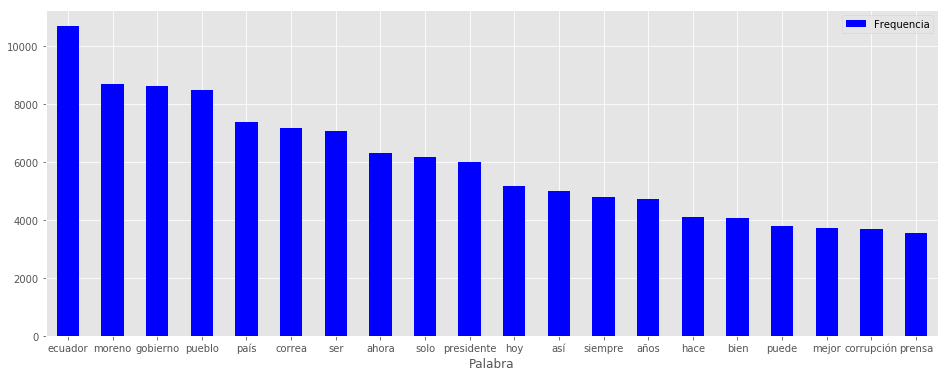

In [40]:
matplotlib.style.use('ggplot')
frecuencia.plot.bar(rot=0, color="blue")

In [43]:
df = df.sample(frac=1)

In [44]:
X_train, y_train = getxy(0,158769)

In [45]:
X_test, y_test = getxy(158770,223769)

In [46]:
X_train.shape, y_train.shape

((158769, 4), (158769, 1))

In [47]:
X_test.shape, y_test.shape

((64990, 4), (64990, 1))

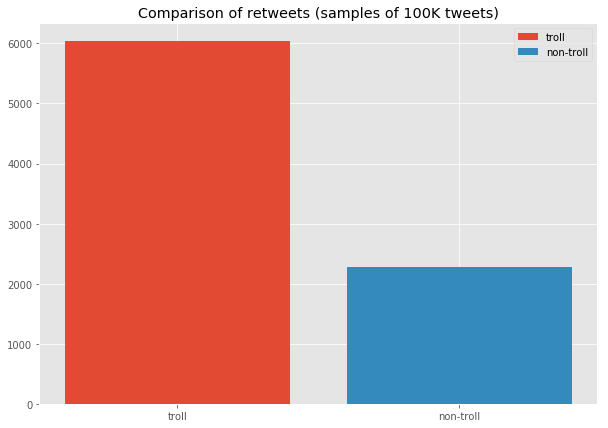

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Comparison of retweets (samples of 100K tweets)')

troll_retweets = np.sum(df_trolls['retweet'].sample(10000))
nontroll_retweets = np.sum(df_users['retweet'].sample(10000))

ax.bar(['troll'],troll_retweets,label='troll')
ax.bar(['non-troll'],nontroll_retweets,label='non-troll')

ax.legend()
plt.show()


### Tokenize words

In [49]:
vocab_size=5000
tokenizer=feature_extraction.text.CountVectorizer(stop_words=stopwords_set, max_features=vocab_size)
tokenizer=tokenizer.fit(df['sin_stopwords'])

In [50]:
X_train_tok=tokenizer.transform(X_train['content'])
X_test_tok=tokenizer.transform(X_test['content'])

### Standarize followers/following

In [167]:
scaler = preprocessing.StandardScaler().fit(X_train[['followers','following']])

In [168]:
'rand means and scales: {}, {}'.format(scaler.mean_, scaler.scale_)

'rand means and scales: [ 1.44105437e-17 -1.11883103e-18], [1. 1.]'

In [169]:
col_to_std = ['followers', 'following']
X_train[col_to_std]=scaler.transform(X_train[col_to_std])
X_test[col_to_std]=scaler.transform(X_test[col_to_std])

In [170]:
X_train[col_to_std].head()

,followers,following
50025,0.868473,-0.211535
60479,-0.152490,-0.242097
26355,-0.151974,-0.092966
48374,-0.128641,0.033527
147518,-0.152768,-0.239550


### Binarize outcome

In [171]:
y_train.head()

,troll
50025,0
60479,1
26355,0
48374,0
147518,1


In [172]:
bool_to_bin = lambda x: 1 if x else 0
y_train['troll'] = y_train['troll'].apply(bool_to_bin)
y_test['troll'] = y_test['troll'].apply(bool_to_bin)

# binarize retweet colum
X_train['retweet'] = X_train['retweet'].apply(bool_to_bin)
X_test['retweet'] = X_test['retweet'].apply(bool_to_bin)

### Concatenate features

In [173]:
def concatenate_features(tok_matrix, data_df):
    """ concatenate the tokenized matrix (scipy.sparse) with other features """
    sparse_cols = sparse.csr_matrix(data_df[['followers', 'following', 'retweet']])
    combined = sparse.hstack([tok_matrix, sparse_cols])
    return combined

In [174]:
X_train_combined = concatenate_features(X_train_tok, X_train)
X_test_combined = concatenate_features(X_test_tok, X_test)

In [175]:
X_train_combined.shape

(158769, 5003)

## Training the model - Logistic Regresion

In [176]:
logic_model = linear_model.LogisticRegression().fit(X_train_combined, y_train['troll'])

In [64]:
logic_model.score(X_train_combined, y_train['troll'])

0.8838249280401086

In [65]:
logic_model.score(X_test_combined, y_test['troll'])

0.8717341129404523

## Creating Neural Net

In [139]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

ImportError: cannot import name get_uid

In [123]:
X_train_combined.shape[1:]

(5003,)

In [124]:
model = Sequential()  # 5003 inputs
model.add(Dense(1024, activation='relu', input_shape=X_train_combined.shape[1:])) # first layer
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))  # second layer 1024 inputs
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))  # third layer  512 inputs
model.add(Dense(1, activation='sigmoid'))  # last layer

NameError: name 'Sequential' is not defined

In [125]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# converting test scipy.sparse matrix to numpy
X_test_matrix = X_test_combined.todense()
X_train_matrix = X_train_combined.todense()

In [63]:
score = model.evaluate(X_test_matrix, y_test['troll'], verbose=0)
accuracy = 100*score[1]

print('Precisi√≥n en el conjunto de prueba: %.4f%%' % accuracy)

Precisi√≥n en el conjunto de prueba: 59.8611%


In [22]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='trolls.model.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train_matrix, y_train['troll'], batch_size=1024, epochs=20, validation_split=0.2, callbacks=[checkpointer], verbose=1, shuffle=True)

ImportError: cannot import name np_utils

In [67]:
model.load_weights('trolls.model.best.hdf5')
score = model.evaluate(X_test_matrix, y_test['troll'], verbose=0)
accuracy = 100*score[1]

# mostrar la precisi√≥n en prubea
print('Precisi√≥n durante la prueba: %.4f%%' % accuracy)

Precisi√≥n durante la prueba: 93.1944%
